## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
# if not os.path.exists('sonnets.txt'):
#     !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [4]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))
vocab_size = len(tokens)
print(f'Total unique tokens: {vocab_size}')

Total unique tokens: 38


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
def idx_to_onehot(idx, vocab_size):
    onehot = np.zeros(vocab_size)
    onehot[idx] = 1
    return onehot

def onehot_to_idx(onehot):
    return np.argmax(onehot)

In [8]:
# dict <index>:<char>
idx_to_token = {idx: char for idx, char in enumerate(tokens)}

# dict <char>:<index>
token_to_idx = {char: idx for idx, char in enumerate(tokens)}

In [9]:
text_onehot = np.array([idx_to_onehot(token_to_idx[char], vocab_size) for char in text])

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [10]:
MAX_LENGTH = 100
SEQ_LENGTH = 100
BATCH_SIZE = 16
HIDDEN_SIZE = 128
EMBEDDING_DIM = 64
NUM_EPOCHS = 50
LEARNING_RATE = 0.0005

In [11]:
class CharRNN(torch.nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.rnn = torch.nn.RNN(embedding_size, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        output, hidden = self.rnn(x, hidden)
        output = self.fc(output.view(1, -1))
        return output, hidden

    def initial_state(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [12]:
model = CharRNN(len(tokens), EMBEDDING_DIM, HIDDEN_SIZE, len(tokens))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Epoch [1/50], Loss: 173.6642
Epoch [2/50], Loss: 164.1364
Epoch [3/50], Loss: 158.0147
Epoch [4/50], Loss: 153.6969
Epoch [5/50], Loss: 151.0183
Epoch [6/50], Loss: 149.3464
Epoch [7/50], Loss: 148.2631
Epoch [8/50], Loss: 147.4918
Epoch [9/50], Loss: 146.8507
Epoch [10/50], Loss: 146.2444
Epoch [11/50], Loss: 145.5848
Epoch [12/50], Loss: 144.8101
Epoch [13/50], Loss: 143.9624
Epoch [14/50], Loss: 143.1188
Epoch [15/50], Loss: 142.3220
Epoch [16/50], Loss: 141.6100
Epoch [17/50], Loss: 140.9945
Epoch [18/50], Loss: 140.4630
Epoch [19/50], Loss: 139.9926
Epoch [20/50], Loss: 139.5563
Epoch [21/50], Loss: 139.1251
Epoch [22/50], Loss: 138.6771
Epoch [23/50], Loss: 138.2103
Epoch [24/50], Loss: 137.7382
Epoch [25/50], Loss: 137.2759
Epoch [26/50], Loss: 136.8343
Epoch [27/50], Loss: 136.4237
Epoch [28/50], Loss: 136.0556
Epoch [29/50], Loss: 135.7399
Epoch [30/50], Loss: 135.4720
Epoch [31/50], Loss: 135.2263
Epoch [32/50], Loss: 134.9672
Epoch [33/50], Loss: 134.6628
Epoch [34/50], Loss

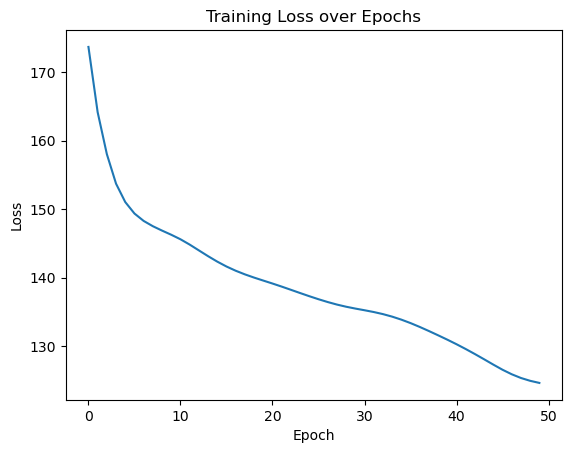

In [13]:
losses = []
for epoch in range(NUM_EPOCHS):
    for i in range(0, len(text) - SEQ_LENGTH, SEQ_LENGTH):
        # Prepare input and target tensors
        input_seq = [token_to_idx[ch] for ch in text[i:i + SEQ_LENGTH]]
        target_seq = [token_to_idx[ch] for ch in text[i + 1:i + 1 + SEQ_LENGTH]]
        input_seq = torch.tensor(input_seq).unsqueeze(1)
        target_seq = torch.tensor(target_seq)

        # Initialize hidden state
        hidden = model.initial_state()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss = 0
        for j in range(SEQ_LENGTH):
            output, hidden = model(input_seq[j], hidden)
            loss += criterion(output, target_seq[j].unsqueeze(0))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')
    losses.append(loss.item())

# Plot the loss function
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [14]:
def generate_sample(char_rnn, seed_phrase=' hello', max_length=500, temperature=1.0):
   
    char_rnn.eval()  # Set to evaluation mode
    generated = seed_phrase
    hidden_state = char_rnn.initial_state(batch_size=1)
    
    # Feed the seed phrase
    for char in seed_phrase[:-1]:
        char_input = torch.tensor([[token_to_idx[char]]], dtype=torch.long)
        _, hidden_state = char_rnn(char_input, hidden_state)
    
    last_char = seed_phrase[-1]
    
    for _ in range(max_length - len(seed_phrase)):
        char_input = torch.tensor([[token_to_idx[last_char]]], dtype=torch.long)
        logits, hidden_state = char_rnn(char_input, hidden_state)
        logits = logits / temperature
        probs = F.softmax(logits, dim=1).data.cpu().numpy().flatten()
        next_idx = np.random.choice(len(tokens), p=probs)
        next_char = idx_to_token[next_idx]
        generated += next_char
        last_char = next_char
    
    return generated

In [15]:
# An example of generated text.
temperatures = [0.1, 0.2, 0.4, 0.5, 0.6, 1.0, 2.0]
for temp in temperatures:
    print(f"Temperature: {temp}")
    print(generate_sample(model, seed_phrase="love ", max_length=200, temperature=temp))
    print("-" * 50)


Temperature: 0.1
love the store to should not the love thee thy self thou art thou thee thy sweet for the world in the store to should my sweet be the store to should my love thee the world my love thee that i am not 
--------------------------------------------------
Temperature: 0.2
love the lies my self thou dost beauty being that the store to subject thou thy self thou thee thy sweet for my love i have sweet soul, that i am all thee thy fair should i thou thy self thou thee tha
--------------------------------------------------
Temperature: 0.4
love the sweet forgot for the store,
    and thou dost as my love to should not the beauty my that i will i coving thee that i what who chear thy self thou lov'd;
  and thou thou thy shall be i compou
--------------------------------------------------
Temperature: 0.5
love that love that thou that me in thee which for the worthiness wronger thee thy love thee thy love that i and for the world the world of the world not stoous my verse is thy

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [16]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.rnn = torch.nn.LSTM(embedding_size, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        output, hidden = self.rnn(x, hidden)  
        output = self.fc(output.view(1, -1))
        return output, hidden

    def initial_state(self, batch_size=1):
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))

In [17]:
model_LSTM = LSTM(len(tokens), EMBEDDING_DIM, HIDDEN_SIZE, len(tokens))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=LEARNING_RATE)

Epoch [1/50], Loss: 172.9455
Epoch [2/50], Loss: 162.8288
Epoch [3/50], Loss: 157.8549
Epoch [4/50], Loss: 155.4223
Epoch [5/50], Loss: 153.2479
Epoch [6/50], Loss: 151.6465
Epoch [7/50], Loss: 150.3747
Epoch [8/50], Loss: 148.8296
Epoch [9/50], Loss: 147.1598
Epoch [10/50], Loss: 145.5684
Epoch [11/50], Loss: 144.0145
Epoch [12/50], Loss: 142.4361
Epoch [13/50], Loss: 140.9568
Epoch [14/50], Loss: 139.6678
Epoch [15/50], Loss: 138.5544
Epoch [16/50], Loss: 137.5213
Epoch [17/50], Loss: 136.4870
Epoch [18/50], Loss: 135.5153
Epoch [19/50], Loss: 134.4464
Epoch [20/50], Loss: 133.5018
Epoch [21/50], Loss: 132.6559
Epoch [22/50], Loss: 131.9632
Epoch [23/50], Loss: 131.2856
Epoch [24/50], Loss: 130.9387
Epoch [25/50], Loss: 130.6755
Epoch [26/50], Loss: 130.2455
Epoch [27/50], Loss: 129.7425
Epoch [28/50], Loss: 129.3440
Epoch [29/50], Loss: 129.0021
Epoch [30/50], Loss: 128.9016
Epoch [31/50], Loss: 129.0075
Epoch [32/50], Loss: 129.2595
Epoch [33/50], Loss: 129.5943
Epoch [34/50], Loss

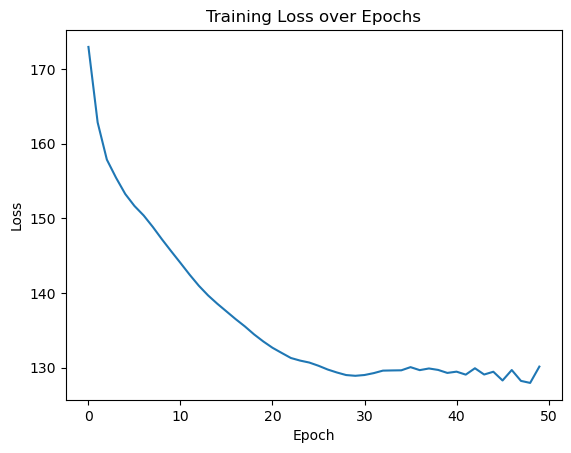

In [18]:
losses = []
for epoch in range(NUM_EPOCHS):
    for i in range(0, len(text) - SEQ_LENGTH, SEQ_LENGTH):
        # Prepare input and target tensors
        input_seq = [token_to_idx[ch] for ch in text[i:i + SEQ_LENGTH]]
        target_seq = [token_to_idx[ch] for ch in text[i + 1:i + 1 + SEQ_LENGTH]]
        input_seq = torch.tensor(input_seq).unsqueeze(1)
        target_seq = torch.tensor(target_seq)

        # Initialize hidden state
        hidden = model_LSTM.initial_state()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss = 0
        for j in range(SEQ_LENGTH):
            output, hidden = model_LSTM(input_seq[j], hidden)
            loss += criterion(output, target_seq[j].unsqueeze(0))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')
    losses.append(loss.item())

# Plot the loss function
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [19]:
def generate_sample(char_rnn, seed_phrase=' hello', max_length=500, temperature=1.0):
    char_rnn.eval()
    generated = seed_phrase
    hidden_state = char_rnn.initial_state(batch_size=1)

    # Feed the seed phrase
    for char in seed_phrase[:-1]:
        char_input = torch.tensor([[token_to_idx[char]]], dtype=torch.long)
        _, hidden_state = char_rnn(char_input, hidden_state)

    last_char = seed_phrase[-1]

    for _ in range(max_length - len(seed_phrase)):
        char_input = torch.tensor([[token_to_idx[last_char]]], dtype=torch.long)
        logits, hidden_state = char_rnn(char_input, hidden_state)
        logits = logits / temperature
        probs = F.softmax(logits, dim=1).data.cpu().numpy().flatten()
        next_idx = np.random.choice(len(tokens), p=probs)
        next_char = idx_to_token[next_idx]
        generated += next_char
        last_char = next_char

    return generated

In [20]:
temperatures = [0.1, 0.2, 0.4, 0.5, 0.6, 1.0, 2.0]
for temp in temperatures:
    print(f"Temperature: {temp}")
    print(generate_sample(model_LSTM, seed_phrase="love ", max_length=200, temperature=temp))
    print("-" * 50)


Temperature: 0.1
love thee,
    to make the true love that false eyes of the lies,
  that thou art thy self thou art thy store,
  and thou art thou the substance can love's with thee,
  when i have so thoughts me thou
--------------------------------------------------
Temperature: 0.2
love thee,
    that thou art thy self and me that thou art thee,
  who hath not so thy fair the will's eye doth thee.

  cxiii

  what i consentle of the fairest can see thee.

  cliii

  loving the t
--------------------------------------------------
Temperature: 0.4
love thee,
    the straight a worthers argument to the lies;
  and the make my love that my store,
  which i course to the expirity doth prove
  and so my heart to be not to the least best,
  that tho
--------------------------------------------------
Temperature: 0.5
love thee.
    to the earth they is as the less thy sinful earth,
  and they see that i am not mine own love,
  to make thou mine eyes know sweet frowne;
  but thou art thou to

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [21]:
# Сохранение
torch.save(model.state_dict(), 'char_rnn_model.pth')
torch.save(model_LSTM.state_dict(), 'LSTM_model.pth')

# # Загрузка
# loaded_model = CharRNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
# loaded_model.load_state_dict(torch.load('char_rnn_model.pth'))

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)